In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt # For making figures
%matplotlib inline

In [4]:
# read in all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [7]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [76]:
#Build the dataset: Train, Dev, and Test
block_size = 3 #context length: How many characters needed to predict the next

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80%
Xdev, Ydev = build_dataset(words[n1:n2]) #10%
Xte, Yte = build_dataset(words[:n2]) #Last 10%


torch.Size([182691, 3]) torch.Size([182691])
torch.Size([22793, 3]) torch.Size([22793])
torch.Size([205484, 3]) torch.Size([205484])


In [77]:
n_embd * block_size

30

In [78]:
#MLP revisited, no more magic numbers for the model
n_embd = 10 #The dimensionality of the character embedding vector
n_hidden = 200 #The Number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / ((n_embd * block_size) ** 0.5)
# Gain / Fan in = 5/3 for Tanh divided by square root of fan in,
# which is n_embd * block_size
# More from https://pytorch.org/docs/stable/nn.init.html
b1 = torch.randn(n_hidden, generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 
# Never use a 0 for the weights
b2 = torch.randn(vocab_size, generator=g) * 0 


parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters)) #number of parameters in total
for p in parameters:
    p.requires_grad = True


SyntaxError: invalid syntax (1949954309.py, line 11)

tensor(-0.0088) tensor(1.0110)
tensor(-0.0015) tensor(0.9907)


(array([2.42346205e-05, 0.00000000e+00, 2.42346205e-05, 2.42346205e-05,
        7.27038616e-05, 7.27038616e-05, 2.42346205e-04, 3.15050067e-04,
        5.81630893e-04, 8.96680960e-04, 1.55101571e-03, 2.66580826e-03,
        4.89539335e-03, 8.96680960e-03, 1.33532759e-02, 2.28047779e-02,
        3.43889265e-02, 5.26860650e-02, 7.79385396e-02, 1.09419312e-01,
        1.47855420e-01, 1.99111642e-01, 2.48283687e-01, 3.03175103e-01,
        3.53025717e-01, 3.87826632e-01, 4.16883942e-01, 4.08232183e-01,
        3.92794730e-01, 3.53704287e-01, 3.16116390e-01, 2.61515790e-01,
        2.10816964e-01, 1.59269926e-01, 1.16980513e-01, 8.25915868e-02,
        5.74845199e-02, 3.79271811e-02, 2.37256935e-02, 1.67218882e-02,
        9.03951346e-03, 5.62243196e-03, 3.07779681e-03, 2.27805433e-03,
        8.96680960e-04, 3.87753929e-04, 2.90815446e-04, 1.93876964e-04,
        7.27038616e-05, 9.69384821e-05]),
 array([-5.59338284, -5.38706642, -5.18075001, -4.97443359, -4.76811718,
        -4.56180077, 

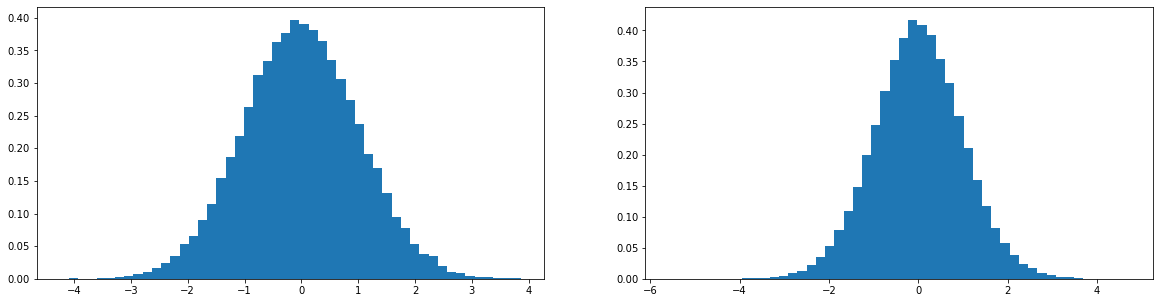

In [75]:
### Example for finding the initial scales for optimizing, 
# essentially the 0.1 and 0.2 in code above
x = torch.randn(1000,30)
w = torch.randn(30, 200) / 30 ** 0.5 ##The fan_in, important for initilization
# Recall , this is for TanH only, for example Relu is (2/n) ** 0.5
#Square root of the connecting dimension, 
# goal is to get standard deviation of 1
y = x @ w
print(x.mean(),x.std()) 
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50, density=True)

In [79]:
#Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #Forward pass
    emb = C[Xb] #Embed characets into the vectors
    embcat = emb.view(emb.shape[0], -1) #Concatenate the vectors        
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #Update
    lr = 0.1 if i < 100000 else 0.01 # Step learning rate decat
    for p in parameters:
        p.data += -lr * p.grad

    #Track Stats
    if i % 10000 == 0: #  Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())



      0/ 200000: 3.3047
  10000/ 200000: 1.9094


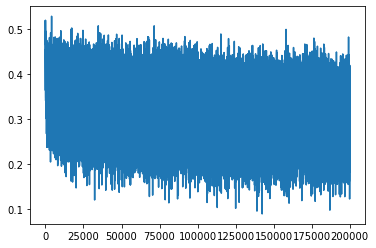

In [66]:
plt.plot(lossi)
# no longer had hocket stick look, weights have been shrunk down 
# so we can see if the loss is on the right path

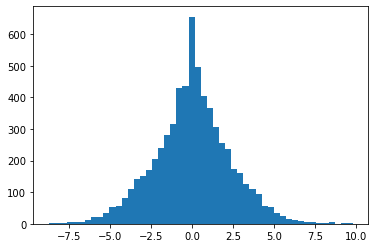

In [67]:
plt.hist(hpreact.view(-1).tolist(),50);
#Preactivation range from (-30,30) to (-7.5,10)
# After intilization fix

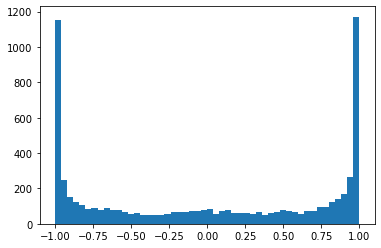

In [68]:
plt.hist(h.view(-1).tolist(),50);

In [69]:
@torch.no_grad() #This decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #Concatenate into (N,block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, vocab_size)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

# Improvements to loss after changes baised on notes from below 
# we had smaller weights and biases for 1st neuron
# Reason fro change was tanh layer was too saturated, 
# shown previously by lot of white space in figure below

train 2.033403158187866
val 2.10168194770813


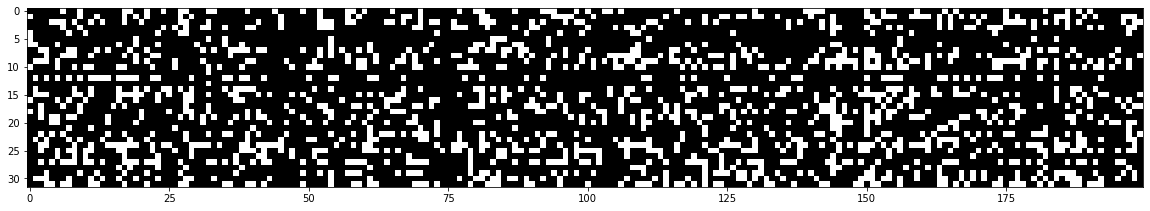

In [70]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray',interpolation='nearest') #Boolean tensor
#Shows how often in a flat region, 
# white if true and black if not
# from 30 examples with 200 neurons

#Lot of white space in first run, so the tanh function was very active
# if mainly black spots, dead neuron

# Same methodoloy for other activation function like
# 1 - Sigmoid
# 2 - Tanh
# 3 - ReLU
# 4 - Leaky ReLU
# 5 - Maxout
# 6 - ELU

# Conclusion, not optimal and need to fix initialization because 
# there are too many extermes in the data, as shown by 2 graphs above

# Initlization fixed , less white 